# Self-Determination Theory (SDT) → Acceptance of AI Mental-Health Interventions (H1)

### Goal of H1

Test whether self-determination (SDT; TENS_Life_mean_imputed) predicts acceptance of:
- Accept_avatar_imputed (AI avatar / generic AI therapist)
- Accept_chatbot_imputed (AI chatbot)
- Accept_tele_imputed (teletherapy / human therapist)
- UTAUT_AI_mean_imputed (general AI-assisted mental-health interventions)

Step 1: Model acceptance as a function of confounders
- General AI attitudes (GAAIS_mean_imputed)
- Epistemic trust (ET_mean_imputed)
- Symptoms, stigma, age, and demographics (controls)

Step 2: Add SDT (TENS) and evaluate its incremental contribution (ΔR²).

No role moderator here (role is unclear in USA); role moderation will be China-only later.

# 0.0 Library Imports and Paths

In [28]:
from __future__ import annotations

import warnings
from pathlib import Path
from typing import Dict, List

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf

warnings.filterwarnings("ignore", category=FutureWarning)

PROJECT_ROOT = Path.cwd()
DATA_DIR = PROJECT_ROOT / "data"
OUTPUT_DIR = DATA_DIR / "output"

PROCESSED_PATH = OUTPUT_DIR / "processed.csv"

# 1.0. Load Processed Data
- We use the fully merged dataset that already contains composite scores and harmonized variables for China + USA.

In [30]:
processed = pd.read_csv(PROCESSED_PATH)
print("Processed shape:", processed.shape)

Processed shape: (2342, 283)


In [31]:
# key *_imputed variables should exist
key_imputed = [
    "TENS_Life_mean_imputed",
    "Accept_avatar_imputed", "Accept_chatbot_imputed", "Accept_tele_imputed",
    "UTAUT_AI_mean_imputed",
    "GAAIS_mean_imputed", "ET_mean_imputed",
    "PHQ5_mean_imputed", "SSRPH_mean_imputed", "age_imputed",
    "Country", "gender"
]

missing_cols = [c for c in key_imputed if c not in processed.columns]
print("Missing key columns:", missing_cols)

Missing key columns: []


# 2.0. Define H1 Variables and Prepare Analytic Sample
Predictor
- TENS_Life_mean_imputed (SDT / basic psychological needs satisfaction)

Outcomes
- Accept_avatar_imputed
- Accept_chatbot_imputed
- Accept_tele_imputed
- UTAUT_AI_mean_imputed

Confounders / Controls
- Primary confounders:
    - GAAIS_mean_imputed (general AI attitudes)
    - ET_mean_imputed (epistemic trust)
- Additional controls:
    - PHQ5_mean_imputed (depressive symptoms)
    - SSRPH_mean_imputed (mental-health stigma)
    - age_imputed (age)
    - gender (categorical)
    - Country (China vs. USA; treated as covariate, not moderator here)

In [32]:
h1_vars = [
    # outcomes
    "Accept_avatar_imputed", "Accept_chatbot_imputed",
    "Accept_tele_imputed", "UTAUT_AI_mean_imputed",
    # predictor
    "TENS_Life_mean_imputed",
    # confounders
    "GAAIS_mean_imputed", "ET_mean_imputed",
    "PHQ5_mean_imputed", "SSRPH_mean_imputed",
    "age_imputed",
    # categorical controls
    "gender", "Country"
]

## 2.1. Keep only rows that have everything needed for H1

In [33]:
h1_df = processed[h1_vars].copy()
n_total = len(h1_df)
h1_df = h1_df.dropna(subset=["gender", "Country"])
n_complete = len(h1_df)

In [34]:
print("H1 analytic sample:")
print(f"Total N in processed: {n_total}")
print(f"N with non-missing gender & Country: {n_complete}")

H1 analytic sample:
Total N in processed: 2342
N with non-missing gender & Country: 2227


In [35]:
print("Country distribution (H1 sample):")
print(h1_df["Country"].value_counts(dropna=False))

Country distribution (H1 sample):
Country
USA      1742
China     485
Name: count, dtype: int64


In [36]:
print("Gender distribution (H1 sample):")
print(h1_df["gender"].value_counts(dropna=False))

Gender distribution (H1 sample):
gender
1.0    1204
2.0     971
3.0      45
4.0       7
Name: count, dtype: int64


# 3.0. Descriptive Statistics for H1 Variables

In [37]:
continuous_vars = [
    "TENS_Life_mean_imputed",
    "Accept_avatar_imputed", "Accept_chatbot_imputed",
    "Accept_tele_imputed", "UTAUT_AI_mean_imputed",
    "PHQ5_mean_imputed", "SSRPH_mean_imputed",
    "GAAIS_mean_imputed", "ET_mean_imputed", "age_imputed"
]

print("Descriptive statistics (continuous variables):")
display(h1_df[continuous_vars].describe().T)

Descriptive statistics (continuous variables):


,count,mean,std,min,25%,50%,75%,max
TENS_Life_mean_imputed,2227.0,4.764543,0.998003,1.000000,4.111111,4.875000,5.500000,7.000000
Accept_avatar_imputed,2227.0,3.708009,0.766785,1.000000,3.272727,3.727273,4.272727,5.000000
Accept_chatbot_imputed,2227.0,3.702916,0.798989,1.000000,3.181818,3.727273,4.272727,5.000000
Accept_tele_imputed,2227.0,2.698673,0.965138,1.000000,1.909091,2.727273,3.454545,5.000000
UTAUT_AI_mean_imputed,2227.0,4.780828,1.368618,1.115385,3.448718,5.000000,6.000000,7.814815
PHQ5_mean_imputed,2227.0,1.415250,1.009685,0.000000,0.600000,1.324076,2.000000,4.000000
SSRPH_mean_imputed,2227.0,1.226999,0.961418,0.000000,0.400000,1.000000,1.800000,4.000000
GAAIS_mean_imputed,2227.0,4.610833,0.794880,2.000000,4.000000,4.625000,5.250000,6.000000
ET_mean_imputed,2227.0,4.260739,0.840602,1.000000,3.666667,4.133333,4.733333,7.000000
age_imputed,2227.0,34.158509,17.157023,1.000000,23.000000,32.000000,46.000000,85.000000


In [42]:
print("Descriptive statistics of continuous variables:")
display(h1_df[continuous_vars].describe().T)

Descriptive statistics of continuous variables:


,count,mean,std,min,25%,50%,75%,max
TENS_Life_mean_imputed,2227.0,4.764543,0.998003,1.000000,4.111111,4.875000,5.500000,7.000000
Accept_avatar_imputed,2227.0,3.708009,0.766785,1.000000,3.272727,3.727273,4.272727,5.000000
Accept_chatbot_imputed,2227.0,3.702916,0.798989,1.000000,3.181818,3.727273,4.272727,5.000000
Accept_tele_imputed,2227.0,2.698673,0.965138,1.000000,1.909091,2.727273,3.454545,5.000000
UTAUT_AI_mean_imputed,2227.0,4.780828,1.368618,1.115385,3.448718,5.000000,6.000000,7.814815
PHQ5_mean_imputed,2227.0,1.415250,1.009685,0.000000,0.600000,1.324076,2.000000,4.000000
SSRPH_mean_imputed,2227.0,1.226999,0.961418,0.000000,0.400000,1.000000,1.800000,4.000000
GAAIS_mean_imputed,2227.0,4.610833,0.794880,2.000000,4.000000,4.625000,5.250000,6.000000
ET_mean_imputed,2227.0,4.260739,0.840602,1.000000,3.666667,4.133333,4.733333,7.000000
age_imputed,2227.0,34.158509,17.157023,1.000000,23.000000,32.000000,46.000000,85.000000


In [44]:
print("\nTENS_Life_mean_imputed by Country:")
display(h1_df.groupby("Country")["TENS_Life_mean_imputed"].describe())


TENS_Life_mean_imputed by Country:


,count,mean,std,min,25%,50%,75%,max
Country,,,,,,,,
China,485.0,4.351203,0.992311,1.00,3.777778,4.333333,5.0,7.0
USA,1742.0,4.879624,0.968961,1.75,4.250000,5.000000,5.5,7.0


In [45]:
print("Acceptance outcomes by Country (imputed):")
display(
    h1_df.groupby("Country")[
        ["Accept_avatar_imputed",
         "Accept_chatbot_imputed",
         "Accept_tele_imputed",
         "UTAUT_AI_mean_imputed"]
    ].mean()
)

Acceptance outcomes by Country (imputed):


,Accept_avatar_imputed,Accept_chatbot_imputed,Accept_tele_imputed,UTAUT_AI_mean_imputed
Country,,,,
China,3.673957,3.692391,3.684413,3.637986
USA,3.717490,3.705846,2.424228,5.099014


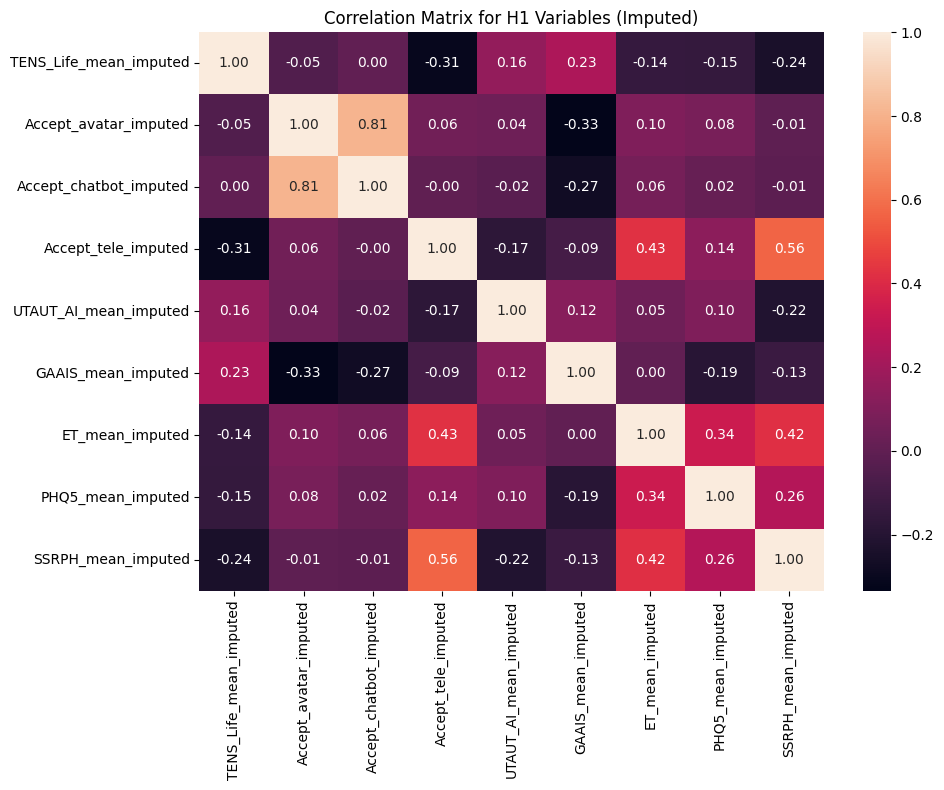

In [46]:
# Correlation matrix for H1 variables
plt.figure(figsize=(10, 8))
corr_vars = [
    "TENS_Life_mean_imputed",
    "Accept_avatar_imputed", "Accept_chatbot_imputed",
    "Accept_tele_imputed", "UTAUT_AI_mean_imputed",
    "GAAIS_mean_imputed", "ET_mean_imputed",
    "PHQ5_mean_imputed", "SSRPH_mean_imputed"
]
sns.heatmap(h1_df[corr_vars].corr(), annot=True, fmt=".2f")
plt.title("Correlation Matrix for H1 Variables (Imputed)")
plt.tight_layout()
plt.show()

# 4.0. Center Continuous Predictors

We mean-center SDT and all continuous confounders. This keeps interpretability and lines up with the later moderation logic.

In [47]:
center_vars = [
    "TENS_Life_mean_imputed",
    "GAAIS_mean_imputed", "ET_mean_imputed",
    "PHQ5_mean_imputed", "SSRPH_mean_imputed",
    "age_imputed"
]

for col in center_vars:
    if col in h1_df.columns:
        h1_df[col + "_c"] = h1_df[col] - h1_df[col].mean()

print("Centered variables created:")
print([c for c in h1_df.columns if c.endswith("_c")])

Centered variables created:
['TENS_Life_mean_imputed_c', 'GAAIS_mean_imputed_c', 'ET_mean_imputed_c', 'PHQ5_mean_imputed_c', 'SSRPH_mean_imputed_c', 'age_imputed_c']


# 5.0. Confounder-Only Models (NO SDT)

we first report confounders (general AI attitudes & trust, plus symptoms, stigma, age, gender, country) before adding SDT.

In [48]:
confounder_outcomes = [
    "Accept_avatar_imputed",
    "Accept_chatbot_imputed",
    "Accept_tele_imputed"
]

confounder_results: Dict[str, sm.regression.linear_model.RegressionResultsWrapper] = {}

for outcome in confounder_outcomes:
    cols_needed = [
        outcome,
        "age_imputed_c",
        "PHQ5_mean_imputed_c", "SSRPH_mean_imputed_c",
        "GAAIS_mean_imputed_c", "ET_mean_imputed_c",
        "gender", "Country"
    ]
    c_df = h1_df[cols_needed].dropna().copy()

    print(f"\nConfounder-only model for {outcome} (N={len(c_df)})")

    formula = (
        f"{outcome} ~ age_imputed_c "
        "+ PHQ5_mean_imputed_c + SSRPH_mean_imputed_c "
        "+ GAAIS_mean_imputed_c + ET_mean_imputed_c "
        "+ C(gender) + C(Country)"
    )

    model = smf.ols(formula=formula, data=c_df).fit()
    confounder_results[outcome] = model

    display(model.summary().tables[1])
    print(f"R² (confounders-only {outcome}): {model.rsquared:.3f}")


Confounder-only model for Accept_avatar_imputed (N=2227)


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,3.6853,0.048,76.097,0.000,3.590,3.780
C(gender)[T.2.0],-0.2162,0.031,-6.968,0.000,-0.277,-0.155
C(gender)[T.3.0],-0.0237,0.108,-0.220,0.826,-0.235,0.188
C(gender)[T.4.0],0.3811,0.268,1.423,0.155,-0.144,0.906
C(Country)[T.USA],0.1486,0.057,2.623,0.009,0.038,0.260
age_imputed_c,-0.0045,0.001,-3.689,0.000,-0.007,-0.002
PHQ5_mean_imputed_c,-0.0264,0.017,-1.594,0.111,-0.059,0.006
SSRPH_mean_imputed_c,-0.0603,0.021,-2.855,0.004,-0.102,-0.019
GAAIS_mean_imputed_c,-0.3140,0.020,-16.003,0.000,-0.353,-0.276
ET_mean_imputed_c,0.1316,0.021,6.396,0.000,0.091,0.172


R² (confounders-only Accept_avatar_imputed): 0.156

Confounder-only model for Accept_chatbot_imputed (N=2227)


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,3.7152,0.052,71.418,0.000,3.613,3.817
C(gender)[T.2.0],-0.1626,0.033,-4.879,0.000,-0.228,-0.097
C(gender)[T.3.0],-0.1145,0.116,-0.988,0.323,-0.342,0.113
C(gender)[T.4.0],0.5068,0.288,1.761,0.078,-0.057,1.071
C(Country)[T.USA],0.0759,0.061,1.247,0.212,-0.043,0.195
age_imputed_c,-0.0034,0.001,-2.608,0.009,-0.006,-0.001
PHQ5_mean_imputed_c,-0.0531,0.018,-2.988,0.003,-0.088,-0.018
SSRPH_mean_imputed_c,-0.0617,0.023,-2.719,0.007,-0.106,-0.017
GAAIS_mean_imputed_c,-0.2805,0.021,-13.308,0.000,-0.322,-0.239
ET_mean_imputed_c,0.1120,0.022,5.066,0.000,0.069,0.155


R² (confounders-only Accept_chatbot_imputed): 0.103

Confounder-only model for Accept_tele_imputed (N=2227)


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,3.2118,0.049,65.041,0.000,3.115,3.309
C(gender)[T.2.0],0.2284,0.032,7.220,0.000,0.166,0.290
C(gender)[T.3.0],-0.4077,0.110,-3.704,0.000,-0.624,-0.192
C(gender)[T.4.0],0.2175,0.273,0.796,0.426,-0.318,0.753
C(Country)[T.USA],-0.7737,0.058,-13.393,0.000,-0.887,-0.660
age_imputed_c,0.0019,0.001,1.550,0.121,-0.001,0.004
PHQ5_mean_imputed_c,-0.0288,0.017,-1.710,0.087,-0.062,0.004
SSRPH_mean_imputed_c,0.2628,0.022,12.195,0.000,0.221,0.305
GAAIS_mean_imputed_c,-0.0925,0.020,-4.621,0.000,-0.132,-0.053
ET_mean_imputed_c,0.2736,0.021,13.038,0.000,0.232,0.315


R² (confounders-only Accept_tele_imputed): 0.446


# 6.0. H1 Models – H1 Models: Add SDT (TENS_Life_mean_imputed_c)

- We test whether SDT adds explanatory power beyond confounders.

In [49]:
print("=== H1: SDT (TENS) → Acceptance per Intervention and Global AI Attitudes ===")

h1_outcomes = [
    "Accept_avatar_imputed",
    "Accept_chatbot_imputed",
    "Accept_tele_imputed",
    "UTAUT_AI_mean_imputed"
]

h1_results: Dict[str, sm.regression.linear_model.RegressionResultsWrapper] = {}

for outcome in h1_outcomes:
    cols_needed = [
        outcome,
        "TENS_Life_mean_imputed_c",
        "age_imputed_c",
        "PHQ5_mean_imputed_c", "SSRPH_mean_imputed_c",
        "GAAIS_mean_imputed_c", "ET_mean_imputed_c",
        "gender", "Country"
    ]

    m_df = h1_df[cols_needed].dropna().copy()

    print(f"\nH1 model for {outcome} (N={len(m_df)})")

    formula = (
        f"{outcome} ~ TENS_Life_mean_imputed_c "
        "+ age_imputed_c "
        "+ PHQ5_mean_imputed_c + SSRPH_mean_imputed_c "
        "+ GAAIS_mean_imputed_c + ET_mean_imputed_c "
        "+ C(gender) + C(Country)"
    )

    model = smf.ols(formula=formula, data=m_df).fit()
    h1_results[outcome] = model

    display(model.summary().tables[1])
    print(f"R² (H1 {outcome}): {model.rsquared:.3f}")

=== H1: SDT (TENS) → Acceptance per Intervention and Global AI Attitudes ===

H1 model for Accept_avatar_imputed (N=2227)


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,3.6859,0.048,76.073,0.000,3.591,3.781
C(gender)[T.2.0],-0.2143,0.031,-6.847,0.000,-0.276,-0.153
C(gender)[T.3.0],-0.0241,0.108,-0.223,0.823,-0.236,0.188
C(gender)[T.4.0],0.3786,0.268,1.413,0.158,-0.147,0.904
C(Country)[T.USA],0.1468,0.057,2.586,0.010,0.035,0.258
TENS_Life_mean_imputed_c,0.0077,0.016,0.476,0.634,-0.024,0.039
age_imputed_c,-0.0045,0.001,-3.708,0.000,-0.007,-0.002
PHQ5_mean_imputed_c,-0.0259,0.017,-1.561,0.119,-0.058,0.007
SSRPH_mean_imputed_c,-0.0597,0.021,-2.818,0.005,-0.101,-0.018
GAAIS_mean_imputed_c,-0.3161,0.020,-15.720,0.000,-0.356,-0.277


R² (H1 Accept_avatar_imputed): 0.156

H1 model for Accept_chatbot_imputed (N=2227)


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,3.7187,0.052,71.571,0.000,3.617,3.821
C(gender)[T.2.0],-0.1506,0.034,-4.488,0.000,-0.216,-0.085
C(gender)[T.3.0],-0.1170,0.116,-1.010,0.312,-0.344,0.110
C(gender)[T.4.0],0.4909,0.287,1.708,0.088,-0.073,1.054
C(Country)[T.USA],0.0649,0.061,1.065,0.287,-0.055,0.184
TENS_Life_mean_imputed_c,0.0477,0.017,2.757,0.006,0.014,0.082
age_imputed_c,-0.0036,0.001,-2.748,0.006,-0.006,-0.001
PHQ5_mean_imputed_c,-0.0501,0.018,-2.818,0.005,-0.085,-0.015
SSRPH_mean_imputed_c,-0.0576,0.023,-2.536,0.011,-0.102,-0.013
GAAIS_mean_imputed_c,-0.2934,0.022,-13.608,0.000,-0.336,-0.251


R² (H1 Accept_chatbot_imputed): 0.106

H1 model for Accept_tele_imputed (N=2227)


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,3.2021,0.049,65.779,0.000,3.107,3.298
C(gender)[T.2.0],0.1952,0.031,6.207,0.000,0.134,0.257
C(gender)[T.3.0],-0.4008,0.108,-3.695,0.000,-0.614,-0.188
C(gender)[T.4.0],0.2615,0.269,0.971,0.332,-0.267,0.789
C(Country)[T.USA],-0.7431,0.057,-13.025,0.000,-0.855,-0.631
TENS_Life_mean_imputed_c,-0.1323,0.016,-8.166,0.000,-0.164,-0.101
age_imputed_c,0.0024,0.001,1.984,0.047,2.81e-05,0.005
PHQ5_mean_imputed_c,-0.0372,0.017,-2.232,0.026,-0.070,-0.005
SSRPH_mean_imputed_c,0.2514,0.021,11.812,0.000,0.210,0.293
GAAIS_mean_imputed_c,-0.0566,0.020,-2.800,0.005,-0.096,-0.017


R² (H1 Accept_tele_imputed): 0.462

H1 model for UTAUT_AI_mean_imputed (N=2227)


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,3.1366,0.080,39.411,0.000,2.981,3.293
C(gender)[T.2.0],-0.0724,0.051,-1.409,0.159,-0.173,0.028
C(gender)[T.3.0],0.1117,0.177,0.630,0.529,-0.236,0.460
C(gender)[T.4.0],0.5995,0.440,1.362,0.173,-0.264,1.463
C(Country)[T.USA],2.1371,0.093,22.912,0.000,1.954,2.320
TENS_Life_mean_imputed_c,0.0948,0.026,3.580,0.000,0.043,0.147
age_imputed_c,-0.0206,0.002,-10.304,0.000,-0.024,-0.017
PHQ5_mean_imputed_c,0.1022,0.027,3.753,0.000,0.049,0.156
SSRPH_mean_imputed_c,0.0344,0.035,0.990,0.322,-0.034,0.103
GAAIS_mean_imputed_c,0.2413,0.033,7.306,0.000,0.177,0.306


R² (H1 UTAUT_AI_mean_imputed): 0.285


# 7.0. ΔR² and Effect Size Summary for TENS
- β_TENS, SE, p, 95% CI
- R²_baseline (where available)
- R²_H1
- ΔR² = R²_H1 - R²_baseline

In [50]:
summary_rows = []

for outcome in h1_outcomes:
    h1_model = h1_results[outcome]
    params = h1_model.params
    bse = h1_model.bse
    pvalues = h1_model.pvalues
    conf = h1_model.conf_int()
    r2_h1 = h1_model.rsquared

    beta_tens = params.get("TENS_Life_mean_imputed_c", np.nan)
    se_tens = bse.get("TENS_Life_mean_imputed_c", np.nan)
    p_tens = pvalues.get("TENS_Life_mean_imputed_c", np.nan)
    ci_low, ci_high = conf.loc["TENS_Life_mean_imputed_c"]

    # Baseline (confounder-only) R² only for the three intervention outcomes
    if outcome in confounder_results:
        r2_base = confounder_results[outcome].rsquared
        delta_r2 = r2_h1 - r2_base
    else:
        r2_base = np.nan
        delta_r2 = np.nan

    summary_rows.append({
        "Outcome": outcome,
        "N": int(h1_model.nobs),
        "beta_TENS": beta_tens,
        "SE_TENS": se_tens,
        "p_TENS": p_tens,
        "CI_low": ci_low,
        "CI_high": ci_high,
        "R2_baseline": r2_base,
        "R2_H1": r2_h1,
        "Delta_R2": delta_r2
    })

h1_summary = pd.DataFrame(summary_rows)
h1_summary


,Outcome,N,beta_TENS,SE_TENS,p_TENS,CI_low,CI_high,R2_baseline,R2_H1,Delta_R2
0,Accept_avatar_imputed,2227,0.007675,0.016131,6.342729e-01,-0.023959,0.039309,0.156061,0.156147,0.000086
1,Accept_chatbot_imputed,2227,0.047699,0.017298,5.873731e-03,0.013776,0.081622,0.103191,0.106258,0.003067
2,Accept_tele_imputed,2227,-0.132347,0.016207,5.294065e-16,-0.164130,-0.100564,0.446145,0.462324,0.016179
3,UTAUT_AI_mean_imputed,2227,0.094848,0.026497,3.514675e-04,0.042887,0.146809,NaN,0.285349,NaN


In [51]:
for _, row in h1_summary.iterrows():
    outcome = row["Outcome"]
    beta = row["beta_TENS"]
    p = row["p_TENS"]
    ci_low = row["CI_low"]
    ci_high = row["CI_high"]
    r2 = row["R2_H1"]
    dR2 = row["Delta_R2"]

    direction = "higher" if beta > 0 else "lower"
    sig = "statistically significant" if p < 0.05 else "not statistically significant"

    print(
        f"For {outcome}, higher SDT (TENS) is associated with {direction} scores "
        f"(β = {beta:.3f}, 95% CI [{ci_low:.3f}, {ci_high:.3f}], p = {p:.3g}), "
        f"after controlling for general AI attitudes (GAAIS), trust, symptoms, stigma, age, "
        f"gender, and country. The full model explains R² = {r2:.3f} of the variance; "
        f"ΔR² attributable to SDT is {dR2:.3f}."
    )

For Accept_avatar_imputed, higher SDT (TENS) is associated with higher scores (β = 0.008, 95% CI [-0.024, 0.039], p = 0.634), after controlling for general AI attitudes (GAAIS), trust, symptoms, stigma, age, gender, and country. The full model explains R² = 0.156 of the variance; ΔR² attributable to SDT is 0.000.
For Accept_chatbot_imputed, higher SDT (TENS) is associated with higher scores (β = 0.048, 95% CI [0.014, 0.082], p = 0.00587), after controlling for general AI attitudes (GAAIS), trust, symptoms, stigma, age, gender, and country. The full model explains R² = 0.106 of the variance; ΔR² attributable to SDT is 0.003.
For Accept_tele_imputed, higher SDT (TENS) is associated with lower scores (β = -0.132, 95% CI [-0.164, -0.101], p = 5.29e-16), after controlling for general AI attitudes (GAAIS), trust, symptoms, stigma, age, gender, and country. The full model explains R² = 0.462 of the variance; ΔR² attributable to SDT is 0.016.
For UTAUT_AI_mean_imputed, higher SDT (TENS) is ass

# 8.0. Visualization – Predicted Acceptance Across SDT Levels
- For each outcome, we plot model-predicted acceptance as a function of TENS_Life_mean (z-transformed) while holding covariates at their mean or reference categories.

In [52]:
def predicted_curve(model, df: pd.DataFrame, predictor_c: str, predictor_raw: str, outcome: str, n_points: int = 50) -> pd.DataFrame:
    # 1. Construct raw and centered predictor grid
    raw_mean = df[predictor_raw].mean()
    raw_std = df[predictor_raw].std()

    x_vals_raw = np.linspace(raw_mean - 2 * raw_std,
                             raw_mean + 2 * raw_std,
                             n_points)
    # Centering consistent with preprocessing step
    x_vals_c = x_vals_raw - raw_mean

    # 2. Choose reference categories for categorical predictors
    ref_gender = df["gender"].mode()[0]
    ref_country = df["Country"].mode()[0]

    # 3. Build prediction DataFrame in terms of the variables
    #    actually used in the model formula
    pred_df = pd.DataFrame({
        predictor_c: x_vals_c,
        "age_imputed_c": 0.0,  # centered → 0 = average age
        "PHQ5_mean_imputed_c": 0.0,
        "SSRPH_mean_imputed_c": 0.0,
        "GAAIS_mean_imputed_c": 0.0,
        "ET_mean_imputed_c": 0.0,
        "gender": ref_gender,
        "Country": ref_country,
    })

    # 4. Get predicted values
    preds = model.predict(pred_df)

    # 5. Return tidy dataframe for plotting
    out = pd.DataFrame({
        predictor_raw: x_vals_raw,
        predictor_c: x_vals_c,
        "predicted": preds,
        "Outcome": outcome
    })
    return out

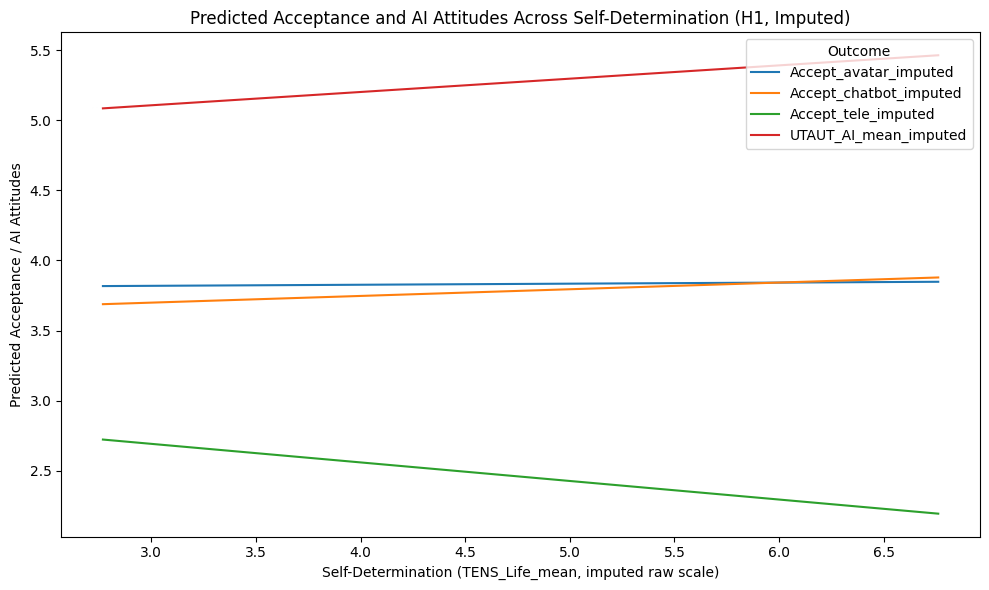

In [53]:
# Build plot data for all H1 outcomes
plot_data = []
for outcome in h1_outcomes:
    model = h1_results[outcome]
    plot_df = predicted_curve(
        model=model,
        df=h1_df,
        predictor_c="TENS_Life_mean_imputed_c",
        predictor_raw="TENS_Life_mean_imputed",
        outcome=outcome,
        n_points=50
    )
    plot_data.append(plot_df)

plot_data = pd.concat(plot_data, ignore_index=True)

# Plot: predicted acceptance / AI attitudes over SDT (TENS)
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=plot_data,
    x="TENS_Life_mean_imputed",
    y="predicted",
    hue="Outcome"
)
plt.xlabel("Self-Determination (TENS_Life_mean, imputed raw scale)")
plt.ylabel("Predicted Acceptance / AI Attitudes")
plt.title("Predicted Acceptance and AI Attitudes Across Self-Determination (H1, Imputed)")
plt.tight_layout()
plt.show()